# Combining Invasive Alien Species and Soil Parameters for Predictive Modelling in Southern Italy

**Authors:** Taimur Khan (UFZ) and Spiros Koulouzis (UVA)

### Introduction

This notebook is a part of the BioDT Hackathon. Here we aim to combine species richness maps from the Invasive Alien Species Digital Twin with the soil data building block to explore further opportunities in predictive modelling. We use southern Italy as the study location. The variables in the soil data building block can be used to predict the distribution of invasive species. The aim  is to help the hackathon participants see how different outputs from BioDT can be combined for further downstream analysis.

### IAS and soil paramters

Invasive alien species (IAS) are species that are introduced to a new environment where they are not native, and they have the potential to cause harm to the environment, economy, or human health. The distribution of IAS is influenced by a number of factors, including climate, land use, and soil properties. Soil properties can influence the distribution of IAS by affecting the availability of nutrients, water, and other resources that are essential for the growth and survival of the species.

The soil data building block provides information on a number of soil parameters, including soil Field Capacity, Permanent Wilting Point, Porosity and Saturated Hydraulic Conductivity. These parameters can be used to predict the distribution of IAS by providing information on the availability of water and nutrients in the soil, which are important factors for the growth and survival of IAS.

### Objective

Combine the [IASDT-output.ipynb](../IASDT/IASDT-outputs.ipynb) and [soil.ipynb](../../03-BuildingBlocks/SoilData/soil.ipynb) to download datasets and use them to predict the distribution of invasive species as a function of soil parameters in southern Italy.

Use the code below as a starting point to combine the two datasets and perform the analysis. You can modify the code as needed to explore different aspects of the data and perform additional analyses. Think about what other data sources you could combine with the IAS and soil data to improve the predictive modelling, and how could you create components using the TwinEco framework to create Digital Twins.



## Datasets

**IAS Species Richness**

To keep things simple, we will only work with scrub habitats and the "Cortaderia selloana" (common name: Pampass grass) plant species under current and future climate scenarios.

To reduce complexity, we take a geospatial subset of the data for **southern Italy**.

:::{note}
You do not need to download the IASDT output data to use it. You can stream it with python/R code. An exmaple in python is rovided below. Simply grab the URL from the BioDT OPeNDAP server and use it in your code. http://opendap.biodt.eu/ias-pdt/0/outputs
:::

**Soil Data**

The soil data building block provides information on a number of soil parameters, including soil Field Capacity, Permanent Wilting Point, Porosity and Saturated Hydraulic Conductivity. We generate some soil datasets for randomized points within the study area.

In [1]:
! pip install git+https://github.com/BioDT/general-soilgrids-soil-data.git@83ce7f1

  Cloning https://github.com/BioDT/general-soilgrids-soil-data.git (to revision 83ce7f1) to /tmp/pip-req-build-rky5cluh
  Running command git clone --filter=blob:none --quiet https://github.com/BioDT/general-soilgrids-soil-data.git /tmp/pip-req-build-rky5cluh
  Running command git checkout -q 83ce7f1
  Resolved https://github.com/BioDT/general-soilgrids-soil-data.git to commit 83ce7f1
  Preparing metadata (setup.py) ... done


### Let's start

Get Pampass grass species richness map from the server for the current time period only:

Slice the data for southern europe and Generate random spatial points in the subset area for downloading soil data:
:

<xarray.DataArray (band: 1, y: 404, x: 390)> Size: 630kB
[157560 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB 2.635e+06 2.645e+06 ... 6.515e+06 6.525e+06
  * y            (y) float64 3kB 5.415e+06 5.405e+06 ... 1.395e+06 1.385e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.99995940923691
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           Sp_0171_mean
EPSG:3035
EPSG:4326
<class 'numpy.ndarray'>


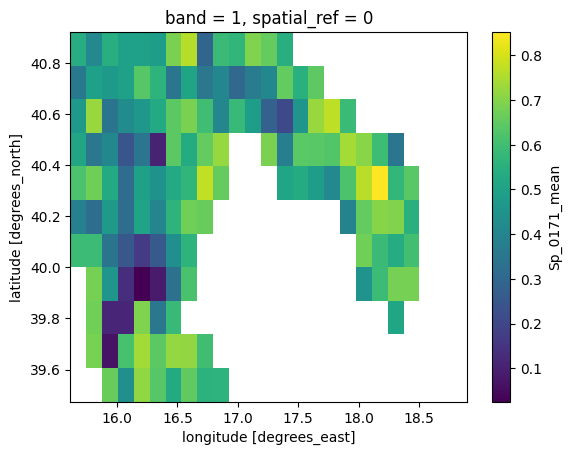

In [21]:
# Define an approximate bounding box for Southern Europe
# (These coordinates are placeholders and may need to be adjusted for your study area)
import rioxarray

import numpy as np
from pyproj import Transformer


conf_current_mean = "http://opendap.biodt.eu/ias-pdt/0/outputs/hab3/predictions/Current/Sp_0171_mean.tif"
tif_data = rioxarray.open_rasterio(conf_current_mean)

print(tif_data)

print(tif_data.rio.crs)
# Convert the CRS to EPSG:4326
tif_data = tif_data.rio.reproject("EPSG:4326")
print(tif_data.rio.crs)


param_minx = 15.721436
param_maxx = 18.803101
param_miny = 39.537940
param_maxy = 40.884448

# Clip the data to the defined bounding box using rioxarray's clip_box function
subset = tif_data.rio.clip_box(minx=param_minx, miny=param_miny, maxx=param_maxx, maxy=param_maxy)

# Plot the clipped data
subset.plot()



# Get the valid coordinates where the data is not NaN
valid_coords = np.column_stack(np.where(~np.isnan(subset.values[0])))

# Convert the valid coordinates to spatial coordinates
valid_x = subset.x.values[valid_coords[:, 1]]
valid_y = subset.y.values[valid_coords[:, 0]]

# Generate random indices to select random points from the valid coordinates
num_points = 40  # Number of random points to generate
random_indices = np.random.choice(len(valid_coords), num_points, replace=False)

# Select the random points
random_points = np.column_stack((valid_x[random_indices], valid_y[random_indices]))


# Initialize the transformer to convert from the current CRS to EPSG:4326
transformer = Transformer.from_crs(subset.rio.crs, "EPSG:4326", always_xy=True)

# Convert the random points to EPSG:4326
random_points_4326 = np.array([transformer.transform(x, y) for x, y in random_points])

print(type(random_points))
random_points_csv_path = '/tmp/data/random_points.csv'
np.savetxt(random_points_csv_path, random_points, delimiter=",")


Plot subset species richness and soil data:

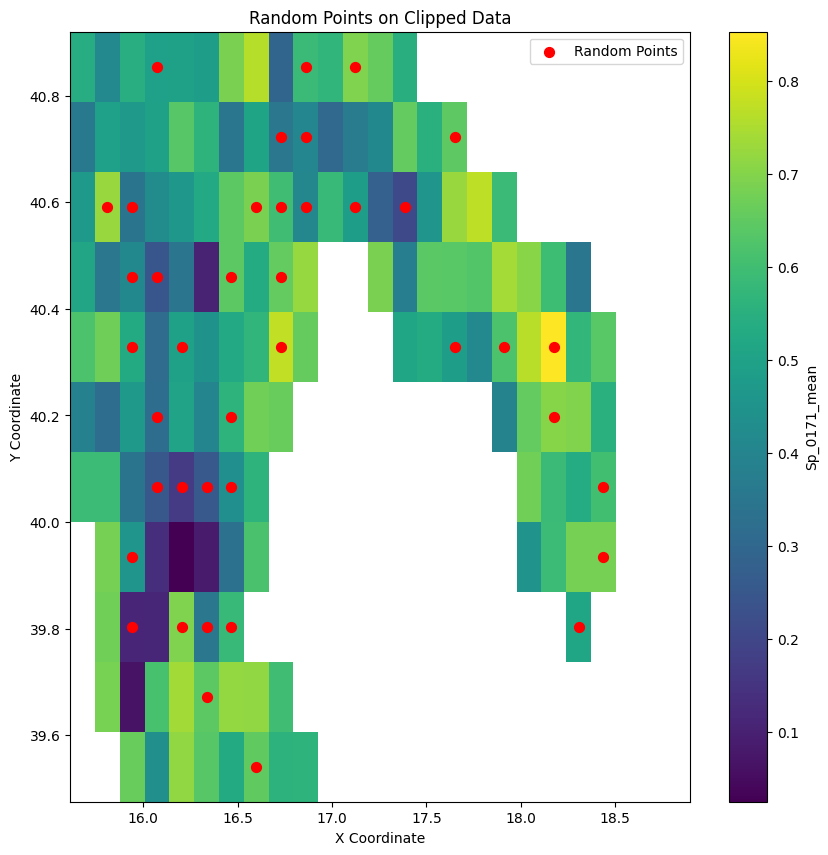

In [23]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tif_data = rioxarray.open_rasterio(conf_current_mean)
tif_data = tif_data.rio.reproject("EPSG:4326")
subset2 = tif_data.rio.clip_box(minx=param_minx, miny=param_miny, maxx=param_maxx, maxy=param_maxy)
random_points2 = np.loadtxt(random_points_csv_path, delimiter=",")

# Plot the clipped data
fig, ax = plt.subplots(figsize=(10, 10))
subset2.plot(ax=ax)

# Plot the random points
ax.scatter(random_points2[:, 0], random_points2[:, 1], color='red', marker='o', s=50, label='Random Points')

# Add labels and legend
ax.set_title('Random Points on Clipped Data')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend()

plt.show()

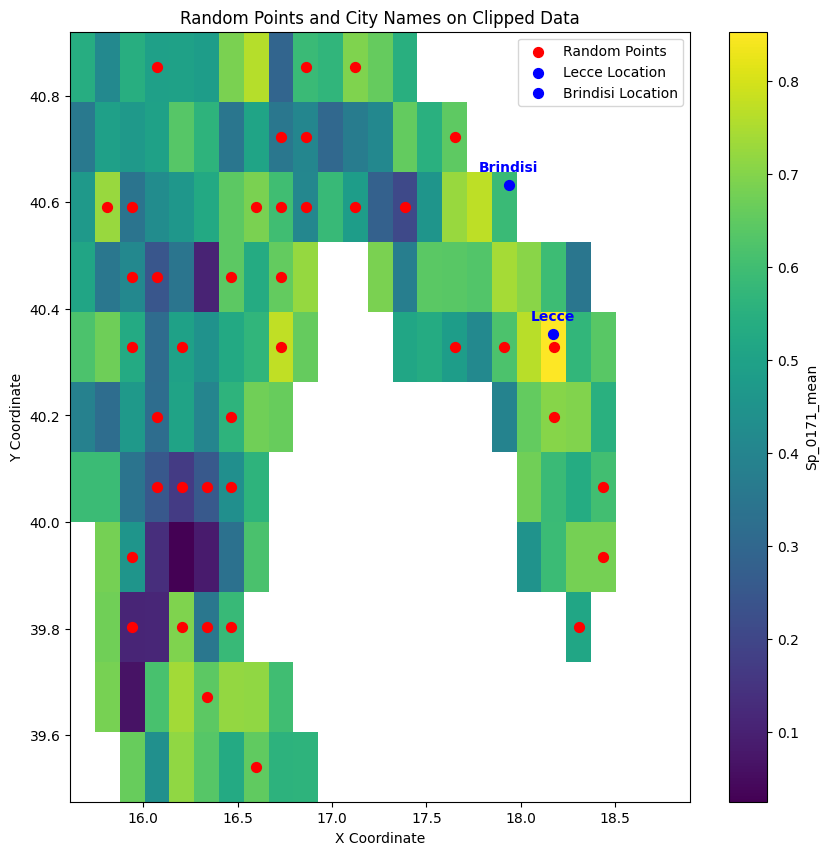

In [25]:
# Define city names and their coordinates

tif_data = rioxarray.open_rasterio(conf_current_mean)
tif_data = tif_data.rio.reproject("EPSG:4326")
subset3 = tif_data.rio.clip_box(minx=param_minx, miny=param_miny, maxx=param_maxx, maxy=param_maxy)
random_points3 = np.loadtxt(random_points_csv_path, delimiter=",")
transformer3 = Transformer.from_crs(subset3.rio.crs, "EPSG:4326", always_xy=True)

cities = {
    "Lecce": (18.1710, 40.3529),
    "Brindisi": (17.9373, 40.6327)
}

# Plot the clipped data
fig, ax = plt.subplots(figsize=(10, 10))
subset3.plot(ax=ax)

# Plot the random points
ax.scatter(random_points3[:, 0], random_points3[:, 1], color='red', marker='o', s=50, label='Random Points')

# Add city names to the plot
for city, (lon, lat) in cities.items():
    x, y = transformer3.transform(lon, lat, direction='INVERSE')
    ax.annotate(f'{city}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='blue', fontweight='bold')
    ax.scatter(lon, lat, color='blue', marker='o', s=50, label=f'{city} Location')

# Add labels and legend
ax.set_title('Random Points and City Names on Clipped Data')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend()

plt.show()

>**Note:** each cell in the grided data represents the species richness at that location. Each grid represent 10x10 KM area.

For each point in the map, download the corresponding soil data:

In [27]:
from pyproj import Transformer
# Convert each point to EPSG:4326 and create a list of dictionaries
tif_data = rioxarray.open_rasterio(conf_current_mean)
tif_data = tif_data.rio.reproject("EPSG:4326")
subset4 = tif_data.rio.clip_box(minx=param_minx, miny=param_miny, maxx=param_maxx, maxy=param_maxy)
random_points4 = np.loadtxt(random_points_csv_path, delimiter=",")
transformer4 = Transformer.from_crs(subset4.rio.crs, "EPSG:4326", always_xy=True)

coordinates_list = []
for point in random_points4:
    lon, lat = transformer4.transform(point[0], point[1])
    coordinates_list.append({"lat": lat, "lon": lon})

print(coordinates_list)

[{'lat': 40.066231603242244, 'lon': 16.466708778816827}, {'lat': 40.46039822863848, 'lon': 16.729486529080983}, {'lat': 40.32900935350641, 'lon': 15.941153278288514}, {'lat': 40.85456485403471, 'lon': 17.123653154477214}, {'lat': 39.67206497784602, 'lon': 16.335319903684745}, {'lat': 39.803453852978095, 'lon': 15.941153278288514}, {'lat': 40.066231603242244, 'lon': 16.20393102855267}, {'lat': 40.066231603242244, 'lon': 18.43754190579799}, {'lat': 40.72317597890264, 'lon': 16.729486529080983}, {'lat': 40.46039822863848, 'lon': 16.07254215342059}, {'lat': 40.85456485403471, 'lon': 16.860875404213058}, {'lat': 40.46039822863848, 'lon': 15.941153278288514}, {'lat': 40.59178710377056, 'lon': 16.5980976539489}, {'lat': 40.59178710377056, 'lon': 15.80976440315644}, {'lat': 40.59178710377056, 'lon': 16.860875404213058}, {'lat': 40.32900935350641, 'lon': 17.64920865500552}, {'lat': 40.32900935350641, 'lon': 17.911986405269676}, {'lat': 40.066231603242244, 'lon': 16.335319903684745}, {'lat': 40.

In [29]:
from soilgrids import data_processing as dprc

for coord in coordinates_list:
    dprc.data_processing(coord)

2025-03-04 17:04:15,493 - INFO - Preparing soil data for latitude: 40.066231603242244, longitude: 16.466708778816827 ...
2025-03-04 17:04:15,496 - INFO - SoilGrids REST API download from https://rest.isric.org/soilgrids/v2.0/properties/query ... 
2025-03-04 17:04:16,726 - INFO - Reading SoilGrids data ...
2025-03-04 17:04:16,729 - INFO - Depth 0-5cm, silt mean: 48.7 %
2025-03-04 17:04:16,731 - INFO - Depth 5-15cm, silt mean: 48.7 %
2025-03-04 17:04:16,733 - INFO - Depth 15-30cm, silt mean: 49.0 %
2025-03-04 17:04:16,735 - INFO - Depth 30-60cm, silt mean: 47.0 %
2025-03-04 17:04:16,737 - INFO - Depth 60-100cm, silt mean: 44.0 %
2025-03-04 17:04:16,739 - INFO - Depth 100-200cm, silt mean: 43.2 %
2025-03-04 17:04:16,741 - INFO - Depth 0-5cm, clay mean: 28.9 %
2025-03-04 17:04:16,743 - INFO - Depth 5-15cm, clay mean: 28.5 %
2025-03-04 17:04:16,745 - INFO - Depth 15-30cm, clay mean: 27.4 %
2025-03-04 17:04:16,747 - INFO - Depth 30-60cm, clay mean: 30.5 %
2025-03-04 17:04:16,752 - INFO - Dep

In [30]:
import pandas as pd
import glob
import re

# Get a list of all soil.txt files in the soilDataPrepared directory
file_list = glob.glob('soilDataPrepared/*_soil.txt')

# Initialize an empty list to store dataframes
df_list = []

# Loop through each file and read it into a dataframe
for file in file_list:
    # Extract latitude and longitude from the file name
    match = re.search(r'lat([-\d.]+)_lon([-\d.]+)', file)
    if match:
        lat = float(match.group(1))
        lon = float(match.group(2))
    
    # Read the file into a dataframe
    df = pd.read_csv(file, sep='\t', skiprows=2)  # Assuming the files are tab-separated
    
    # Add latitude and longitude as new columns
    df['Latitude'] = lat
    df['Longitude'] = lon
    
    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
soil_data_df = pd.concat(df_list, ignore_index=True)

print(soil_data_df)

      Layer  FC[V%]  PWP[V%]  POR[V%]  KS[mm/d]   Latitude  Longitude
0       1.0  43.285   14.720   50.490  177.2410  40.066232  16.466709
1       2.0  40.810   14.055   48.215  198.8285  40.066232  16.466709
2       3.0  39.960   13.960   47.220  204.2980  40.066232  16.466709
3       4.0  41.170   13.660   46.130   62.3310  40.066232  16.466709
4       5.0  41.170   13.660   46.130   62.3310  40.066232  16.466709
...     ...     ...      ...      ...       ...        ...        ...
1175   16.0  39.310   14.740   43.120   55.6030  40.591787  16.598098
1176   17.0  39.310   14.740   43.120   55.6030  40.591787  16.598098
1177   18.0  39.310   14.740   43.120   55.6030  40.591787  16.598098
1178   19.0  39.310   14.740   43.120   55.6030  40.591787  16.598098
1179   20.0  39.310   14.740   43.120   55.6030  40.591787  16.598098

[1180 rows x 7 columns]


In [35]:
# Initialize an empty list to store species richness values

tif_data = rioxarray.open_rasterio(conf_current_mean)
tif_data = tif_data.rio.reproject("EPSG:4326")
subset5 = tif_data.rio.clip_box(minx=param_minx, miny=param_miny, maxx=param_maxx, maxy=param_maxy)
random_points5 = np.loadtxt(random_points_csv_path, delimiter=",")
transformer5 = Transformer.from_crs(subset5.rio.crs, "EPSG:4326", always_xy=True)


species_richness_values = []
soil_data_df = pd.concat(df_list, ignore_index=True)

# Loop through each row in the dataframe
for index, row in soil_data_df.iterrows():
    # Get the latitude and longitude
    lat = row['Latitude']
    lon = row['Longitude']
    
    # Get the corresponding species richness value from the subset dataset
    species_richness = subset5.sel(x=lon, y=lat, method='nearest').values[0]
    
    # Append the species richness value to the list
    species_richness_values.append(species_richness)

# Add the species richness values as a new column in the dataframe
soil_data_df['Species_Richness'] = species_richness_values

print(soil_data_df)
print(type(soil_data_df))
soil_data_csv_path = '/tmp/data/soil_data.csv'
soil_data_df.to_csv(soil_data_csv_path, sep=',')

      Layer  FC[V%]  PWP[V%]  POR[V%]  KS[mm/d]   Latitude  Longitude  \
0       1.0  43.285   14.720   50.490  177.2410  40.066232  16.466709   
1       2.0  40.810   14.055   48.215  198.8285  40.066232  16.466709   
2       3.0  39.960   13.960   47.220  204.2980  40.066232  16.466709   
3       4.0  41.170   13.660   46.130   62.3310  40.066232  16.466709   
4       5.0  41.170   13.660   46.130   62.3310  40.066232  16.466709   
...     ...     ...      ...      ...       ...        ...        ...   
1175   16.0  39.310   14.740   43.120   55.6030  40.591787  16.598098   
1176   17.0  39.310   14.740   43.120   55.6030  40.591787  16.598098   
1177   18.0  39.310   14.740   43.120   55.6030  40.591787  16.598098   
1178   19.0  39.310   14.740   43.120   55.6030  40.591787  16.598098   
1179   20.0  39.310   14.740   43.120   55.6030  40.591787  16.598098   

      Species_Richness  
0             0.433944  
1             0.433944  
2             0.433944  
3             0.433944 

In [36]:
# Calculate the correlation matrix

soil_data_df = pd.read_csv(soil_data_csv_path)

correlation_matrix = soil_data_df.corr()

# Extract the correlation values for Species_Richness
species_richness_correlation = correlation_matrix["Species_Richness"]

print(species_richness_correlation)

Unnamed: 0          4.198824e-02
Layer               6.037069e-17
FC[V%]             -4.329077e-01
PWP[V%]            -8.075649e-02
POR[V%]            -3.413148e-01
KS[mm/d]            2.284179e-01
Latitude            6.938248e-02
Longitude           3.143283e-01
Species_Richness    1.000000e+00
Name: Species_Richness, dtype: float64
